## **Torch to TRT Conversion Code**

**1. Start with Installing the right packages on Machine to enable Conversion**

In [ ]:
# pip install git
!git clone https://github.com/NVIDIA-AI-IOT/torch2trt


Cloning into 'torch2trt'...
remote: Enumerating objects: 4030, done.
remote: Counting objects: 100% (498/498), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 4030 (delta 284), reused 442 (delta 274), pack-reused 3532
Receiving objects: 100% (4030/4030), 7.83 MiB | 26.57 MiB/s, done.
Resolving deltas: 100% (2235/2235), done.


In [ ]:
cd torch2trt

/content/torch2trt


In [ ]:
!pip install nvidia-pyindex
!pip install nvidia-tensorrt
!python3 /content/torch2trt/setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8416 sha256=e642dd7af36001efc390a2b02f5c0af9cf7b7ee2ef8c210723a2550fed2f14d4
  Stored in directory: /root/.cache/pip/wheels/f1/a1/a1/6cc45cc1ae6b1876f12ef399c0d0d6e18809e9ced611c7c2a7
Successfully built nvidia-pyindex
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 774.4 MB 16 kB/s 
     |████████████████████████████████| 333.1 MB 36 kB/s 
     |████████████████████████████████| 849 kB 52.0 MB/s 
     |████████████████████████████████| 719.3 MB 18 kB/s 
  Created wheel for nvidia-cublas-cu11: filename=nvidia_cublas_cu11-2022.4.8-py3-none-any.whl size=15624 sha256=b8ea6d3495094309aa7e7d17a035630196cbdd5f28ee25cf4c1461a9d989f01e
  Stored in directory: /root/.cache/pip/wheels/e2/c3/94/1f

In [ ]:
!cmake -B build . && cmake --build build --target install && ldconfig

**2. Import Google Drive Input Information (Must add to local Google Drive)**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

**3. Import all needed Libraries!**

In [ ]:
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage import io, transform
import torch.utils.data as data_utils
import os
import pandas as pd
import numpy as np
import torch
import torch2trt.torch2trt
from pandas.core.frame import DataFrame
from os import listdir
from os.path import isfile, join

In [ ]:
import time

**4. Import Standard Code from Kaggle to input data**

In [ ]:
class DogBreedsDataset(Dataset):
    """Dog Breeds dataset."""

    def __init__(self, csv_file, root_dir, files, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        df = pd.read_csv(csv_file)
        df = df[df['id'].isin(files)]
        self.labels_frame = df
        
        self.map = dict(zip(self.labels_frame['breed'].unique(),range(0,len(self.labels_frame['breed'].unique()))))
        self.labels_frame['breed'] = self.labels_frame['breed'].map(self.map)
        self.root_dir = root_dir
        self.transform = transform
        
    def getmap(self):
        return self.map
        
    def __getclasses__(self):
        return self.labels_frame['breed'].unique().tolist()

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.labels_frame.iloc[idx, 0])
        img_name = img_name + '.jpg'
        
        image = io.imread(img_name)
        PIL_image = Image.fromarray(image)
        label = self.labels_frame.iloc[idx, 1:]
        label = [int(label) for x in label]
        label = np.asarray(label)
        label = torch.from_numpy(label)
        if self.transform:
            image = self.transform(PIL_image)
        #sample = {'image': image, 'label': label}
        return image,label

**4.1 Import Settings from Tkinter**

In [ ]:
import re
import json
settings_path = '/content/gdrive/MyDrive/settings/data.json'
with open(settings_path) as f:
    json_data = json.load(f)
print(json_data)


batch_size = json_data['batch_size']
batch_size = 1
# percentage of training set to use as validation
valid_size = 1.0
dtype = json_data['dtype']
load = json_data['load']
model_file = json_data['model']
input_size = tuple(re.findall(r'\d+', json_data['input_size']))


**4.2 Add new Code to input Training Data set up Accuracy Testing**

In [ ]:
mypath = '/content/gdrive/MyDrive/input/train'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

filenames_evaluate = []
for i in onlyfiles:
  new_name = i[:-4]
  filenames_evaluate.append(new_name)
filenames_evaluate[:load+1]

df_labelEval = pd.read_csv('/content/gdrive/MyDrive/input/labels.csv')
df_labelEval = df_labelEval[df_labelEval['id'].isin(filenames_evaluate)]

transform = transforms.Compose([transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transforms = transforms.Compose([
                                      transforms.ToTensor()])

train_data = DogBreedsDataset(csv_file='/content/gdrive/MyDrive/input/labels.csv',root_dir='/content/gdrive/MyDrive/input/train', transform=transform, files = filenames_evaluate)


In [ ]:

classes = train_data.__getclasses__()
print(classes)
#obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

valid_sampler = SubsetRandomSampler(valid_idx)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)

gpu_test = torch.cuda.is_available()
criterion = nn.CrossEntropyLoss()

In [ ]:
gpu_test = torch.cuda.is_available()
criterion = nn.CrossEntropyLoss()

In [ ]:
model_base = torch.load('/content/gdrive/MyDrive/input/model.pt')

if gpu_test:
  print("Torch Model in CUDA Setting")
  model_base

data_trt_input = torch.randn((1,3,224,224)).cuda()

if dtype == "fp16":
  model_torch_convert = model_base.cuda().half().eval()
  data_trt_input = data_trt_input.half()
  model_trt = torch2trt.torch2trt(model_torch_convert, [data_trt_input], fp16_mode=True)

if dtype == "int8":
  model_torch_convert = model_base.cuda().type('torch.int8').eval()
  # data_trt_input = data_trt_input.type('torch.int8')
  model_trt = torch2trt.torch2trt(model_torch_convert, [data_trt_input], int8_mode=True, max_batch_size=batch_size)

model_torch = model_base.cuda().eval()

Torch Model Evaluation

In [29]:
time_start = time.time()
model_torch.cuda()
count = 0
valid_loss = 0
for batch_i, (data, target) in enumerate(valid_loader):
  if count > load:
    break
  count += 1
  
  # move tensors to GPU if CUDA is available
  if gpu_test:
      time.sleep(0.01)
      data, target = data.cuda(), target.cuda()
  
  # data_example = data
  output = model_torch(data.half())
  # print(output)
  # print(target)
  # calculate the batch loss
  loss = criterion(output, torch.max(target, 1)[1])
  
  # update training loss 
  valid_loss += loss.item()
  
  if batch_i % batch_size == batch_size-1:    # print validation loss every specified number of mini-batches
      print('Load Testing Torch %d loss: %.16f' %
            (batch_i + 1, valid_loss / batch_size))
      valid_loss = 0.0
time_end = time.time()

time_diff_torch = time_end - time_start
print("Total Time:" + str(time_diff_torch))


Load Testing Torch 1 loss: 0.0003287792205811
Load Testing Torch 2 loss: 0.0000472068786621
Load Testing Torch 3 loss: 0.0000003576278687
Load Testing Torch 4 loss: 0.0000077486038208
Load Testing Torch 5 loss: 0.0000201463699341
Load Testing Torch 6 loss: 0.0001021623611450
Load Testing Torch 7 loss: 0.0000081062316895
Load Testing Torch 8 loss: 0.0003004074096680
Load Testing Torch 9 loss: 0.0000863075256348
Load Testing Torch 10 loss: 0.0031013488769531
Load Testing Torch 11 loss: 0.0059051513671875
Load Testing Torch 12 loss: 0.0003027915954590
Load Testing Torch 13 loss: 0.0001275539398193
Load Testing Torch 14 loss: 0.0000264644622803
Load Testing Torch 15 loss: 0.0024089813232422
Load Testing Torch 16 loss: 0.0014581680297852
Load Testing Torch 17 loss: 0.0001050233840942
Load Testing Torch 18 loss: 0.0102310180664062
Load Testing Torch 19 loss: 0.0000131130218506
Load Testing Torch 20 loss: 0.0000990629196167
Load Testing Torch 21 loss: 0.0000432729721069
Load Testing Torch 22 

TensorRT Model Valuation

In [30]:
time_start = time.time()
count = 0

for batch_i, (data, target) in enumerate(valid_loader):
        if count > load:
          break
        count += 1
        # move tensors to GPU if CUDA is available
        if gpu_test:
            data, target = data.cuda(), target.cuda()

        if dtype == "fp16":
          data = data.half()
          # target = target.type('torch.half')
        if dtype == "int8":
          data = data.type('torch.int8')
          # target = target.type('torch.half')

        # print(data.shape)
        output = model_trt(data)
        # print(target)
        # calculate the batch loss
        # print(output)
        loss = criterion(output, torch.max(target, 1)[1])
        
        # update training loss 
        valid_loss += loss.item()
        
        if batch_i % batch_size == batch_size-1:    # print validation loss every specified number of mini-batches
            print('Load testing TRT %d loss: %.16f' %
                  (batch_i + 1, valid_loss / batch_size))
            valid_loss = 0.0

time_end = time.time()

time_diff_trt = time_end - time_start
print("Total Time TRT:" + str(time_diff_trt))



Load testing TRT 1 loss: 0.0010023117065430
Load testing TRT 2 loss: 0.0002046823501587
Load testing TRT 3 loss: 0.0020198822021484
Load testing TRT 4 loss: 0.0005574226379395
Load testing TRT 5 loss: 0.0000990629196167
Load testing TRT 6 loss: 0.0000569820404053
Load testing TRT 7 loss: 0.0003287792205811
Load testing TRT 8 loss: 0.0000990629196167
Load testing TRT 9 loss: 0.0000346899032593
Load testing TRT 10 loss: 0.0007429122924805
Load testing TRT 11 loss: 0.0002689361572266
Load testing TRT 12 loss: 0.0000790357589722
Load testing TRT 13 loss: 0.0058593750000000
Load testing TRT 14 loss: 0.0014467239379883
Load testing TRT 15 loss: 0.0000430345535278
Load testing TRT 16 loss: 0.0005989074707031
Load testing TRT 17 loss: 0.0035552978515625
Load testing TRT 18 loss: 0.0016098022460938
Load testing TRT 19 loss: 0.0012578964233398
Load testing TRT 20 loss: 0.0093460083007812
Load testing TRT 21 loss: 0.0004453659057617
Load testing TRT 22 loss: 0.0000131130218506
Load testing TRT 23

Check Max Error Between Models

In [34]:
time_start = time.time()
count = 0
max_error_array = []

for batch_i, (data, target) in enumerate(valid_loader):
        if count > load:
          break
        count += 1
        if gpu_test:
            data, target = data.cuda(), target.cuda()

        output_torch = model_torch(data.half())

        if dtype == "fp16":
          data = data.half()
        if dtype == "int8":
          data = data.type('torch.int8')

        output_trt = model_trt(data)
        max_error_array.append(float(torch.max(torch.abs(output_torch - output_trt))))




        # print('max error: %f' % float(torch.max(torch.abs(output_torch - output_trt))))

time_end = time.time()

time_diff_trt = time_end - time_start
print("Total Time TRT:" + str(time_diff_trt))

Total Time TRT:1.165020227432251


**Plot Results for Viewing**

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


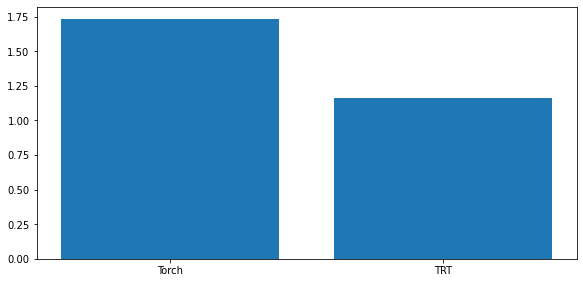

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Torch', 'TRT']
time = [time_diff_torch, time_diff_trt]

ax.bar(langs,time)
plt.show()

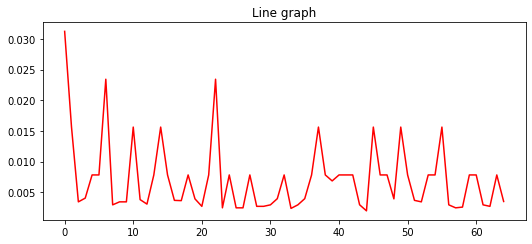

In [38]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

y_range = []
for i in range(count):
  y_range.append(i)



x = np.array(max_error_array)
y =  np.array(y_range)

plt.title("Line graph")
plt.plot(y, x, color="red")

plt.show()

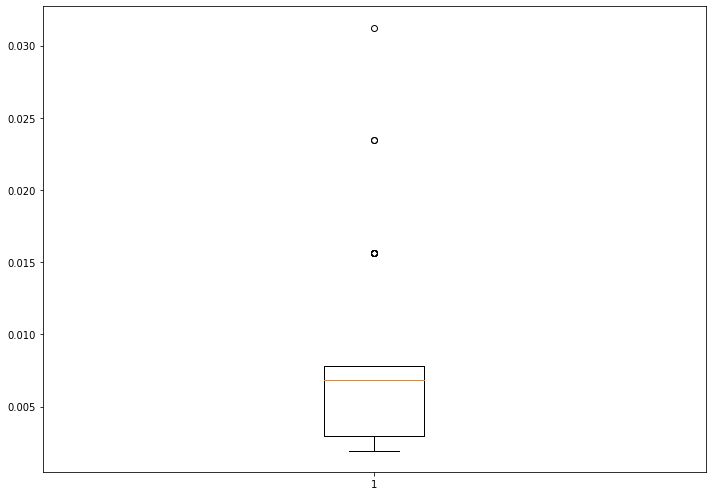

In [39]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
# Creating dataset

max_error_np = np.array(max_error_array)

 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(max_error_np)
 
# show plot
plt.show()